# Data Creation, Exploration and Filtering

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import json
from helpers import *
from collections import Counter
data_folder = './DATA/'

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lucil\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lucil\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
C:\Users\lucil\anaconda3\envs\ada\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\lucil\anaconda3\envs\ada\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


## Table of Contents
- [Historical Timeline](#section-1)
- [Importing raw data](#section-2)
- [Movie dataset: Filtering](#section-3)
- [Character Dataset: Filtering](#section-4)
    - [Merging personas with character dataset](#subsection-4.1)
- [Complementing the dataset after 2010](#section-5)
    - [A) Complementing movie data](#subsection-5.1)
    - [B) Complementing and cleaning up the genres of the movie data](#subsection-5.2)
    - [C) Complementing characters' data](#subsection-5.3)
- [First Analysis of the character data](#section-6)
    - [A) Analysis of actors' gender and age](#subsection-6.1) 
    - [B) Personas Analysis](#subsection-6.2)

# Historical Timeline
<a id='section-1'></a>
In our analysis we want to see how representation of women in american movies might be impacted by historical events. We therefore need to retrieve a history timeline. We decided to use the timeline on https://www.history.com/topics/womens-history/womens-history-us-timeline since it contains major events related to women's history in the US.

In [2]:
get_history_timeline()

Successfully accessed https://www.history.com/topics/womens-history/womens-history-us-timeline
Timeline saved in DATA/timeline.csv


## Importing raw data
<a id='section-2'></a>

In [3]:
movies_metadata = pd.read_csv(data_folder+'movie.metadata.tsv', header=None, sep='\t',
                              names=['wikipedia_ID','freebase_ID','name','release_date',
                                     'box_office_revenue', 'runtime', 'languages', 'countries', 'genre'],
                              parse_dates=False)
movies_metadata.head(5)

,wikipedia_ID,freebase_ID,name,release_date,box_office_revenue,runtime,languages,countries,genre
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


In [4]:
character_metadata = pd.read_csv(data_folder+'character.metadata.tsv', header=None, sep='\t',
                                 names=['wikipedia_ID','freebase_ID','release_date', 'character_name',
                                        'actor_birthday', 'actor_gender', 'actor_height', 'actor_ethnicity',
                                        'actor_name' , 'actor_age','freebase_character_actor_mapID', 'freebase_character_ID', 'freebase_actor_ID' ], parse_dates=False)
character_metadata.head(5)

,wikipedia_ID,freebase_ID,release_date,character_name,actor_birthday,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,freebase_character_actor_mapID,freebase_character_ID,freebase_actor_ID
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


In [5]:
plot_summaries = pd.read_csv(data_folder+'plot_summaries.txt',sep='\t', header=None,
                             names=['wikipedia_ID', 'plot_summary'] )
plot_summaries.head()

,wikipedia_ID,plot_summary
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
1,31186339,The nation of Panem consists of a wealthy Capi...
2,20663735,Poovalli Induchoodan is sentenced for six yea...
3,2231378,"The Lemon Drop Kid , a New York City swindler,..."
4,595909,Seventh-day Adventist Church pastor Michael Ch...


## Movie dataset: Filtering
<a id='section-3'></a>

#### How many movies do we have?

In [6]:
number_of_data= movies_metadata.count()
number_of_data

wikipedia_ID          81741
freebase_ID           81741
name                  81741
release_date          74839
box_office_revenue     8401
runtime               61291
languages             81741
countries             81741
genre                 81741
dtype: int64

#### Where is data mostly missing ?

In [7]:
proportion_of_each_data = number_of_data/number_of_data['wikipedia_ID']*100
proportion_of_each_data

wikipedia_ID          100.000000
freebase_ID           100.000000
name                  100.000000
release_date           91.556257
box_office_revenue     10.277584
runtime                74.981955
languages             100.000000
countries             100.000000
genre                 100.000000
dtype: float64

We see that the box office column is a column with a lot of missing data, it is only present for 10% of movies. This will not impact our analysis as we are not planning on using the box office as a metric.
One caveat of these results is that an empty list will not be considered as a missing. So for languages, countries and genres this percentages do not really represent the missing data.

Given we will perform our analysis on American movies we will only keep the data for movies from the US

In [8]:
us_movies_metadata = movies_metadata[movies_metadata['countries'].str.contains('United States of America',
                                                                               case=False)].copy()
us_movies_metadata

,wikipedia_ID,freebase_ID,name,release_date,box_office_revenue,runtime,languages,countries,genre
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
5,13696889,/m/03cfc81,The Gangsters,1913-05-29,NaN,35.0,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/09c7w0"": ""United States of America""}","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen..."
7,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938-08-16,3600000.0,106.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/04t36"": ""Musical"", ""/m/01z4y"": ""Comedy"", ..."
10,175026,/m/017n1p,Sarah and Son,1930,NaN,86.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/07s9rl0"": ""Drama"", ""/m/01g6gs"": ""Black-an..."
...,...,...,...,...,...,...,...,...,...
81725,1918494,/m/0660qx,State and Main,2000-08-26,6944471.0,106.0,"{""/m/02bjrlw"": ""Italian Language"", ""/m/02h40lc...","{""/m/0f8l9c"": ""France"", ""/m/09c7w0"": ""United S...","{""/m/0gf28"": ""Parody"", ""/m/09n5t_"": ""Americana..."
81726,664006,/m/030xw6,Guilty as Sin,1993-06-04,22886222.0,107.0,{},"{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
81727,24209227,/m/07k5mlk,"The Time, the Place and the Girl",1946,NaN,105.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/05p553"": ""Comedy film"", ""/m/02l7c8"": ""Rom..."
81736,35228177,/m/0j7hxnt,Mermaids: The Body Found,2011-03-19,NaN,120.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/07s9rl0"": ""Drama""}"


How many movies did we keep?

In [9]:
print(us_movies_metadata.count())

wikipedia_ID          34408
freebase_ID           34408
name                  34408
release_date          33197
box_office_revenue     6936
runtime               29509
languages             34408
countries             34408
genre                 34408
dtype: int64


In [10]:
print('Total Number of movies', number_of_data.wikipedia_ID)
print('Number of non-US movies', number_of_data.wikipedia_ID - us_movies_metadata.wikipedia_ID.count())

Total Number of movies 81741
Number of non-US movies 47333


In [11]:
#Let's remove the dictionaries from the countries, the genre and languages of our data
us_movies_metadata['countries'] = us_movies_metadata['countries'].apply(lambda x:
                                                                        list(ast.literal_eval(x).values()))
us_movies_metadata['genre'] = us_movies_metadata['genre'].apply(lambda x:
                                                                list(ast.literal_eval(x).values()))
us_movies_metadata['languages'] = us_movies_metadata['languages'].apply(lambda x:
                                                                        list(ast.literal_eval(x).values()))

# convert dates to same format and remove movies with unknown movie release dates
us_movies_metadata['release_date'] = us_movies_metadata['release_date'].astype(str)
us_movies_metadata['release_date'] = pd.to_datetime(us_movies_metadata['release_date'],
                                                    format='mixed', errors='coerce')
us_movies_metadata = us_movies_metadata.dropna(subset=['release_date']).copy()

Let's see what languages we still have in our data

In [12]:
us_movies_metadata["languages"].explode().unique()

array(['English Language', 'Silent film', nan, 'Spanish Language',
       'Greek Language', 'Swahili Language', 'French Language',
       'Standard Mandarin', 'Standard Cantonese', 'Italian Language',
       'Japanese Language', 'American English', 'German Language',
       'Arabic Language', 'Czech Language', 'Slovak Language',
       'Thai Language', 'Portuguese Language', 'Polish Language',
       'Tibetan languages', 'Mandarin Chinese', 'Cantonese',
       'Standard Tibetan', 'Chinese language', 'Swedish Language',
       'Hungarian language', 'Russian Language', 'Dutch Language',
       'Persian Language', 'Irish', 'American Sign Language',
       'Tagalog language', 'Filipino language', 'Xhosa Language',
       'Afrikaans Language', 'Urdu Language', 'Hebrew Language',
       'Tamil Language', 'Latin Language', 'Turkish Language',
       'Hindi Language', 'Serbo-Croatian', 'Croatian language',
       'Serbian language', 'Kannada Language', 'Punjabi language',
       'Bengali Langu

Of interest for us are: English Language, Silent Film, American English, Old English Language (for example Indian English is not very relevant for our analysis, as well as native american languages like Navajo or Hawaiian language). So let us remove any movie that doesn't have English Language, Silent Film, American English, Old English Language, or American Sign Language as one of their language

In [13]:
us_english_movies_metadata = us_movies_metadata[movies_metadata['languages'].str.contains('English Language'
                                                                                          or 'Silent Film'
                                                                                          or 'American English'
                                                                                          or 'Old English Language'
                                                                                          or 'American Sign Language',
                                                                                          case=False)].copy()

C:\Users\lucil\AppData\Local\Temp\ipykernel_1548\1512204378.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  us_english_movies_metadata = us_movies_metadata[movies_metadata['languages'].str.contains('English Language'


Did we remove any movies by doing that?

In [14]:
print('We had',us_movies_metadata.wikipedia_ID.count(), 'movies in our U.S data frame')
print('We now have', us_english_movies_metadata.wikipedia_ID.count(), 'in our English US data frame')
print('So there are',us_movies_metadata.wikipedia_ID.count()-us_english_movies_metadata.wikipedia_ID.count(),
      'movies that were from the US but not in any of the languages we decided to consider.')
print('We also see that in the movies we removed, there are',
      np.sum(us_movies_metadata['languages'].apply(lambda x: len(x)==0)),
      'movies that lack languages. For the next milestone we will thus find out the languages of these movies to complete the dataset.')

We had 33197 movies in our U.S data frame
We now have 29830 in our English US data frame
So there are 3367 movies that were from the US but not in any of the languages we decided to consider.
We also see that in the movies we removed, there are 3022 movies that lack languages. For the next milestone we will thus find out the languages of these movies to complete the dataset.


#### Now let us have a look at the genres we have in our dataset

In [15]:
us_english_movies_metadata["genre"].explode().unique()

array(['Thriller', 'Science Fiction', 'Horror', 'Adventure',
       'Supernatural', 'Action', 'Space western', 'Mystery',
       'Biographical film', 'Drama', 'Crime Drama', 'Short Film',
       'Silent film', 'Indie', 'Black-and-white', 'Comedy', 'Musical',
       'Romantic comedy', 'Ensemble Film', 'Comedy-drama',
       'Romantic drama', 'Romance Film', "Children's/Family", 'Fantasy',
       'Family Film', "Children's Fantasy", 'Future noir',
       'Erotic thriller', 'Film adaptation', 'Crime Fiction',
       'Coming of age', 'Marriage Drama', 'Western', 'Fan film',
       'Black comedy', 'War film', 'Epic', 'Biopic [feature]',
       'Historical Epic', 'Action/Adventure', 'Costume drama',
       'Historical fiction', 'Culture & Society', 'Biography',
       'Documentary', 'Christmas movie', 'Television movie',
       'Action Comedy', 'Cult', 'Blaxploitation', 'Martial Arts Film',
       'Epic Western', 'Softcore Porn', 'Sexploitation', 'Parody',
       'B-movie', 'Zombie Film', 'C

As we can see we have a massive amount (342) of genres, so at some point we will need to filter or chose certain genres to analyze.

#### Plot of the number of movies per year

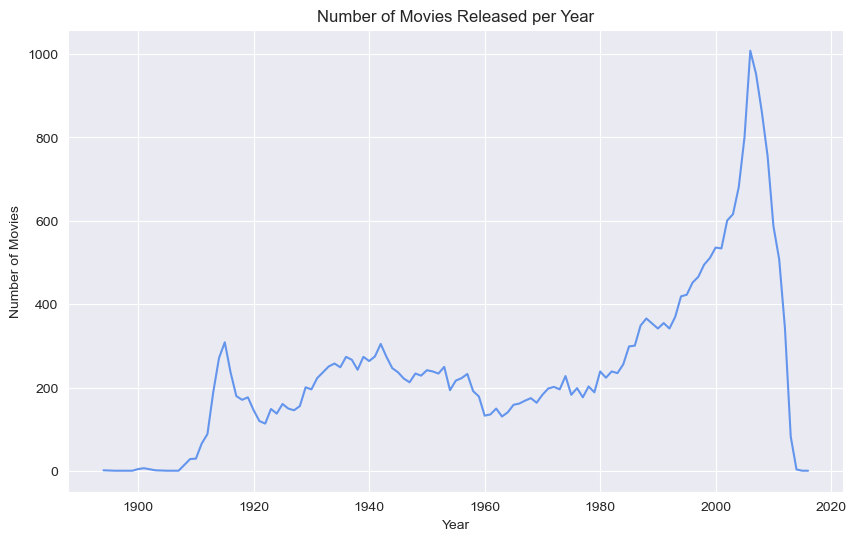

In [16]:
# Group movies by release year
movies_grouped_by_year = us_english_movies_metadata.groupby(us_english_movies_metadata['release_date'].dt.year)

#number of movies per year
number_movies_per_year = movies_grouped_by_year.size()

plt.figure(figsize=(10, 6))
number_movies_per_year.plot(kind='line', color = 'cornflowerblue')
plt.title('Number of Movies Released per Year')
plt.xlabel('Year')
plt.ylabel('Number of Movies')
plt.grid(True)
plt.show()

We can see on this plot that before 1912 we have very little movies. We will thus only keep movies from 1912 and later years.

In [17]:
us_english_movies_metadata = us_english_movies_metadata[us_english_movies_metadata['release_date'].dt.year >= 1912]

Let us merge this movies dataframe with the synopses

In [18]:
us_english_movies_synopsis = pd.merge(us_english_movies_metadata, plot_summaries, how='left',
                                      on = 'wikipedia_ID')

In [19]:
us_english_movies_synopsis

,wikipedia_ID,freebase_ID,name,release_date,box_office_revenue,runtime,languages,countries,genre,plot_summary
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...","Set in the second half of the 22nd century, th..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,[English Language],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]",NaN
2,13696889,/m/03cfc81,The Gangsters,1913-05-29,NaN,35.0,"[Silent film, English Language]",[United States of America],"[Short Film, Silent film, Indie, Black-and-whi...",NaN
3,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938-08-16,3600000.0,106.0,[English Language],[United States of America],"[Musical, Comedy, Black-and-white]",NaN
4,175026,/m/017n1p,Sarah and Son,1930-01-01,NaN,86.0,[English Language],[United States of America],"[Drama, Black-and-white]",NaN
...,...,...,...,...,...,...,...,...,...,...
29662,34474142,/m/0cpy07r,Frontier Fury,1943-06-24,NaN,55.0,[English Language],[United States of America],[Western],NaN
29663,1918494,/m/0660qx,State and Main,2000-08-26,6944471.0,106.0,"[Italian Language, English Language]","[France, United States of America]","[Parody, Americana, Comedy]",Havoc is wrought on the inhabitants of a small...
29664,24209227,/m/07k5mlk,"The Time, the Place and the Girl",1946-01-01,NaN,105.0,[English Language],[United States of America],"[Comedy film, Romance Film, Musical]",NaN
29665,35228177,/m/0j7hxnt,Mermaids: The Body Found,2011-03-19,NaN,120.0,[English Language],[United States of America],[Drama],Two former National Oceanic Atmospheric Admini...


Do we have a lot of missing summaries?

In [20]:
missing_plot = us_english_movies_synopsis['plot_summary'].isna().sum()
number_of_movies = len(us_english_movies_synopsis['plot_summary'])
print('We only have', number_of_movies- missing_plot, 'movies out of',number_of_movies,
      "with a summary, which means we only have 60.59% of the movies with the plotline. However, the plot summary analysis might be too costly to run on a lot of summaries. It might therefore be reasonable not to complete the missing plot summaries." )

We only have 18805 movies out of 29667 with a summary, which means we only have 60.59% of the movies with the plotline. However, the plot summary analysis might be too costly to run on a lot of summaries. It might therefore be reasonable not to complete the missing plot summaries.


# Character Dataset: Filtering
<a id='section-4'></a>

Let's start by checking the completeness of the character dataset:

In [21]:
number_of_data_character= character_metadata.count()
proportion_of_each_data_character = number_of_data_character/number_of_data_character['wikipedia_ID']*100
proportion_of_each_data_character

wikipedia_ID                      100.000000
freebase_ID                       100.000000
release_date                       97.782186
character_name                     42.779512
actor_birthday                     76.447237
actor_gender                       89.879712
actor_height                       34.354260
actor_ethnicity                    23.533458
actor_name                         99.727516
actor_age                          64.915936
freebase_character_actor_mapID    100.000000
freebase_character_ID              42.781731
freebase_actor_ID                  99.819158
dtype: float64

The data seems pretty complete regarding the release date of the movies, actor's gender and actor's age. Nevertheless, we need  to complete the dataset with more character's name to be able to analyze deeper the personas associated with them and use this result in our analysis. getting also more data on actors' ethnicity would also be of choice as this will allow us to extend our analysis to other minorities such as people of color.

In [22]:
# remove unknown release dates
character_metadata = character_metadata.dropna(subset='release_date')
# convert the release_date to a date format (YYYY/MM/DD
# but any date that initially only has a year will be converted to YYYY/01/01)
character_metadata['release_date'] = character_metadata['release_date'].astype(str)
character_metadata['release_date'] = pd.to_datetime(character_metadata['release_date'], format = 'mixed',
                                                    errors='coerce').dt.year

First we will only keep the characters related to the movies we previously filtered

In [23]:
us_movie_mask = character_metadata['wikipedia_ID'].isin(us_english_movies_metadata['wikipedia_ID'])
character_metadata = character_metadata[us_movie_mask]

Let's filter the character metadata to remove actors with a gender differing from F or M. However, let's first explore the values that "gender" take.

In [24]:
# Check values in the "actor_gender" column
character_metadata.loc[character_metadata.actor_gender.isna(), "actor_gender"] = "NA"
display(character_metadata.groupby("actor_gender").count().actor_name)

actor_gender
F      67647
M     141440
NA     17185
Name: actor_name, dtype: int64

As expected, actor's gender is either F (female), M (male) or NA (not mentionned). Nevertheless, this check was necessary in order to make sure no one identified as non-binary for example. Let's now remove the actors with NA as gender as well as all the characters in movies that have no release date as our analysis is related to time.


In [25]:
# remove any value that is not "F" or "M" in the "gender" column or the character metadata, keeps the rest
character_metadata_noNA_gender = character_metadata[character_metadata["actor_gender"].isin(["F", "M"])].copy()
# drop the characters in movies with no release date
character_metadata_noNA_genderYear = character_metadata_noNA_gender.dropna(subset=['release_date']).copy()

display(character_metadata_noNA_genderYear)
print('From the original character dataset, we dropped ',
      character_metadata.shape[0]-character_metadata_noNA_genderYear.shape[0],
      'characters either because the movie had no release date or the gender of the actor was not specified, out of ', character_metadata.shape[0], 'characters initially.')

,wikipedia_ID,freebase_ID,release_date,character_name,actor_birthday,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,freebase_character_actor_mapID,freebase_character_ID,freebase_actor_ID
0,975900,/m/03vyhn,2001.0,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001.0,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001.0,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001.0,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001.0,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg
...,...,...,...,...,...,...,...,...,...,...,...,...,...
450638,30553937,/m/0g9ts5h,1998.0,Restaurant Manager,NaN,M,NaN,NaN,Randy Harris,NaN,/m/0jxtsx5,/m/0jxtsx8,/m/0jxtsxh
450639,30553937,/m/0g9ts5h,1998.0,Julia,1975-10-10,F,NaN,NaN,Natalie Ramsey,22.0,/m/0jxtsw7,/m/0jxtswb,/m/027dt0m
450640,7223293,/m/0kv0xs,1925.0,NaN,1894-02-28,M,NaN,NaN,Sid Smith,NaN,/m/02vcw0s,NaN,/m/02qrq5t
450641,9971909,/m/02pygw1,1972.0,NaN,1938-11-26,M,NaN,NaN,Rich Little,33.0,/m/02vbk4r,NaN,/m/03m6t5


From the original character dataset, we dropped  17841 characters either because the movie had no release date or the gender of the actor was not specified, out of  226929 characters initially.


### Merging personas with character dataset
<a id='subsection-4.1'></a>

In [26]:
# Read the data from the text file, comma is the delimiter
personnas_metadata = pd.read_csv(data_folder + 'tvtropes.clusters.txt', names=['personnas', 'data'],
                                 header=None, sep='\t')

# Replace single quotes with a placeholder character, to avoid error in parsing
personnas_metadata['data'] = personnas_metadata['data'].str.replace("'", "@@QUOTE@@")
personnas_metadata['data'] = personnas_metadata['data'].apply(lambda x: x.replace("@@QUOTE@@", "'"))

# Function to load JSON strings
def json_loads(x):
    try:
        return json.loads(x)
    except (ValueError, SyntaxError):
        print(f"Error decoding JSON: {x}")
        return None

# Parse the JSON-like strings and split them into separate columns
personnas_metadata['data'] = personnas_metadata['data'].apply(json_loads)
personnas_metadata = pd.concat([personnas_metadata.drop('data', axis=1),
                                personnas_metadata['data'].apply(pd.Series)], axis=1)

#Rename the id column so it matches with the character dataset to be able
# to merge (information from the README file) --> maps the actor with its character in
# the character metadata dataset
personnas_metadata.rename(columns={'id': 'freebase_character_actor_mapID'}, inplace=True)

display(personnas_metadata)

,personnas,char,movie,freebase_character_actor_mapID,actor
0,absent_minded_professor,Professor Philip Brainard,Flubber,/m/0jy9q0,Robin Williams
1,absent_minded_professor,Professor Keenbean,Richie Rich,/m/02vchl3,Michael McShane
2,absent_minded_professor,Dr. Reinhardt Lane,The Shadow,/m/0k6fkc,Ian McKellen
3,absent_minded_professor,Dr. Harold Medford,Them!,/m/0k6_br,Edmund Gwenn
4,absent_minded_professor,Daniel Jackson,Stargate,/m/0k3rhh,James Spader
...,...,...,...,...,...
496,young_gun,Morgan Earp,Tombstone,/m/0k776f,Bill Paxton
497,young_gun,Colorado Ryan,Rio Bravo,/m/0k2kqg,Ricky Nelson
498,young_gun,Tom Sawyer,The League of Extraordinary Gentlemen,/m/0k5nsh,Shane West
499,young_gun,William H. 'Billy the Kid' Bonney,Young Guns II,/m/03lrjk0,Emilio Estevez


Let's merge this data with the character data we have on freebase_character_actor_mapID as this relates the personas with the actor and the character they play in a specific movie.

In [27]:
# only add the column personas to the characters dataset
character_metadata_noNA_genderYear_personnas = \
    character_metadata.merge(personnas_metadata[['freebase_character_actor_mapID', 'personnas']],
                             on=["freebase_character_actor_mapID"],how="left").copy()

display(character_metadata_noNA_genderYear_personnas)

,wikipedia_ID,freebase_ID,release_date,character_name,actor_birthday,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,freebase_character_actor_mapID,freebase_character_ID,freebase_actor_ID,personnas
0,975900,/m/03vyhn,2001.0,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7,NaN
1,975900,/m/03vyhn,2001.0,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4,NaN
2,975900,/m/03vyhn,2001.0,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l,NaN
3,975900,/m/03vyhn,2001.0,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc,NaN
4,975900,/m/03vyhn,2001.0,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
226975,30553937,/m/0g9ts5h,1998.0,Restaurant Manager,NaN,M,NaN,NaN,Randy Harris,NaN,/m/0jxtsx5,/m/0jxtsx8,/m/0jxtsxh,NaN
226976,30553937,/m/0g9ts5h,1998.0,Julia,1975-10-10,F,NaN,NaN,Natalie Ramsey,22.0,/m/0jxtsw7,/m/0jxtswb,/m/027dt0m,NaN
226977,7223293,/m/0kv0xs,1925.0,NaN,1894-02-28,M,NaN,NaN,Sid Smith,NaN,/m/02vcw0s,NaN,/m/02qrq5t,NaN
226978,9971909,/m/02pygw1,1972.0,NaN,1938-11-26,M,NaN,NaN,Rich Little,33.0,/m/02vbk4r,NaN,/m/03m6t5,NaN


Finally, we will add the name of the movies to the dataset to facilitate merges with datasets that do not have wikipedia ID.

In [28]:
character_metadata_noNA_genderYear_personnas = \
    pd.merge(character_metadata_noNA_genderYear_personnas, movies_metadata[['wikipedia_ID', 'name']],
             how='left', on='wikipedia_ID')

# Complementing the dataset after 2010
<a id='section-5'></a>
The provided dataset does not contain information on recent movies. We thus decided to complement it using IMDB data to be able to also perform our analysis in recent years. We have two main datasets to complete: the movie dataset and the character dataset. To do so, we used the data available on https://datasets.imdbws.com/ and the library Cinemagoer that can retrieve information on IMDB.

### A) Complementing movie data
<a id='subsection-5.1'></a>
To complete the movie dataset we used the following folders need to be downloaded from https://datasets.imdbws.com/, unzipped and placed in the /DATA folder:
- title.basics.tsv.gz
- title.akas.tsv.gz

However, these files are missing a lot information that we need for our analysis (plot summaries, countries, languages). We will therefore also use the library Cinemagoer to retrieve these information. In order to not have too many useless requests to IMDB through Cinemagoer, we use the datasets title.basics and titles.akas to get a list of ID of movies we are interested in.

In [29]:
# If files unzipped on Windows
titles_dataset = pd.read_csv(data_folder + 'title.basics.tsv/data.tsv', sep='\t')
# If files unzipped on Mac
#titles_dataset = pd.read_csv(data_folder + 'title.basics.tsv', sep='\t')
movie_IDs = filter_titles_IDs(titles_dataset)

C:\Users\lucil\AppData\Local\Temp\ipykernel_1548\1054908203.py:2: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  titles_dataset = pd.read_csv(data_folder + 'title.basics.tsv/data.tsv', sep='\t')


In [30]:
print(len(movie_IDs)) # we still have 204'389

204389


Taking all of these movies from IMDB would take too much time. These IDs contain movies from a lot of different countries and we are only interested in american movies. We do not have the 'country' information in the downloaded datasets but we do have the 'original title' and the 'american title' in the title.akas dataset. We will use this dataset to find movies in which the original title is the same as the american one. Thus we can already remove some movies that we know are probably not american. We will of course keep a lot of non-american movies, but we can filter those out later.


In [31]:
# If files unzipped on Windows
titles_akas_dataset = pd.read_csv(data_folder + 'title.akas.tsv/data.tsv', sep='\t')
# If files unzipped on Mac
#titles_akas_dataset = pd.read_csv(data_folder + 'title.akas.tsv', sep='\t')
original_titles = titles_akas_dataset[titles_akas_dataset['isOriginalTitle']==1]['title']
# get all only the lines where the title is the same as the original title
titles_akas_dataset_filtered = titles_akas_dataset[titles_akas_dataset['title'].isin(original_titles)]
# get only the movies where the US title is the same as the original title
titles_akas_dataset_filtered = titles_akas_dataset_filtered[titles_akas_dataset_filtered['region'] == 'US']

C:\Users\lucil\AppData\Local\Temp\ipykernel_1548\1564436681.py:2: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  titles_akas_dataset = pd.read_csv(data_folder + 'title.akas.tsv/data.tsv', sep='\t')


In [32]:
# get only IDs that are in both datasets
common_ids = titles_akas_dataset_filtered[titles_akas_dataset_filtered['titleId'].isin(movie_IDs)]
common_ids = common_ids['titleId'].drop_duplicates()
print(len(common_ids)) # 39'595 movies left

39595


We will now retrieve information of these 39'595 movies directly from IMDB using Cinemagoer

!! THE FOLLOWING CELL TAKES A LONG TIME TO RUN !!
Since it has already been run once and the data was saved, there is no need to run it anymore and it is thus commented.

In [33]:
#get_IMDB_movies_data(common_ids)

We filter the movies to only keep american movies in English from 2010-2022. Note that filter according to the release year again, even thought the movies to get on IMDB were already filtered according to their release date. That is because both datasets did not have necessarily the same release date for the same movie and thus a second filtering is necessary.

In [34]:
IMDB_movie_data = pd.read_csv(data_folder + 'IMDB_movies_2010-2022.csv')
IMDB_movie_data_filtered = filter_IMDB_movie_dataset(IMDB_movie_data)

In [35]:
IMDB_movie_data_filtered

,IMDB_ID,name,release_date,languages,countries,genre,plot_summary
1,tt0112502,Bigfoot,2017,['English'],['United States'],"['Horror', 'Thriller']","['A story of a man who, after having been thro..."
2,tt0172182,Blood Type,2018,['English'],['United States'],"['Comedy', 'Drama', 'Mystery']","['During a frantic police car chase, a fleeing..."
3,tt0195933,Mysteries,2019,['English'],['United States'],NaN,NaN
4,tt0293429,Mortal Kombat,2021,"['English', 'Japanese', 'Chinese']",['United States'],"['Action', 'Adventure', 'Fantasy', 'Sci-Fi', '...","[""MMA fighter Cole Young seeks out Earth's gre..."
5,tt0297400,Snowblind,2015,['English'],"['United States', 'Canada']","['Crime', 'Drama']","['Revealing the entrepreneurial ingenuity, par..."
...,...,...,...,...,...,...,...
39579,tt9913056,Swarm Season,2019,['English'],['United States'],['Documentary'],"[""On the remote volcanic island of Hawaii, 10-..."
39580,tt9913288,Letters,2020,['English'],['United States'],['Drama'],"[""Charlie Porter is an ordinary man. He leads ..."
39586,tt9914522,The Holden Family Plan,2019,['English'],['United States'],"['Drama', 'Family']","[""When Mackenzie Holden's sister and brother i..."
39587,tt9914582,However Long,2019,['English'],['United States'],['Documentary'],['Documentary following four women with incura...


We now have a datasets containing all the needed information on movies from 2010-2022. We just need to merge it with the provided dataset.

In [36]:
provided_data = us_english_movies_synopsis
# change the release date to just the year to be able to merge more easily and convert it to the same format
# of the other df
provided_data['release_date'] = provided_data['release_date'].dt.year
# country and languages are not needed anymore
provided_data = provided_data.drop(columns=['languages', 'countries'])
IMDB_movie_data_filtered = IMDB_movie_data_filtered.drop(columns=['languages', 'countries'])
# put movie names to lower case in both datasets so that they are recognised as the same movie name
# even if there are differences in the case
provided_data['name'] = name_to_lowercase(provided_data, 'name')
IMDB_movie_data_filtered['name'] = name_to_lowercase(IMDB_movie_data_filtered, 'name')

Since we do not have a unique identifier for both datasets (one has wikipedia ID, the other IMDB ID), we use the columns 'name' and 'release_date' to do the merge. However, it can happen that two movies with the same name are released in the same year. In the case where only one of the movie is present in a dataset and both are present in the other, the merge could be wrong and assign an ID of the wrong movie. After the merge, we will thus drop all duplicated movie IDs. This will make us loose some films but will ensure that our merge does not contain mistakes.

For the next milestone, we will retrieve the IMDB IDs corresponding to the movies in the provided CMU database by querying wikipedia, in order to be able to perform a merge on an unique identifier

In [37]:
# merge IMDB and provided dataset
movie_data = pd.merge(provided_data, IMDB_movie_data_filtered, on=['name', 'release_date'], how='outer').copy()
duplicated_cols = ['plot_summary', 'genre']
movie_data = remove_duplicated_columns(movie_data, duplicated_cols)
# remove duplicated IDs except the ones that contain NaNs in one of the ID
movie_data = movie_data[~movie_data.duplicated(subset='wikipedia_ID', keep=False) |
                        movie_data['wikipedia_ID'].isnull()]
movie_data = movie_data[~movie_data.duplicated(subset='IMDB_ID', keep=False) |
                        movie_data['IMDB_ID'].isnull()]

In [38]:
movie_data

,wikipedia_ID,freebase_ID,name,release_date,box_office_revenue,runtime,genre,plot_summary,IMDB_ID
0,975900.0,/m/03vyhn,ghosts of mars,2001,14010832.0,98.0,"[Thriller, Science Fiction, Horror, Adventure,...","Set in the second half of the 22nd century, th...",NaN
1,3196793.0,/m/08yl5d,getting away with murder: the jonbenét ramsey ...,2000,NaN,95.0,"[Mystery, Biographical film, Drama, Crime Drama]",NaN,NaN
2,13696889.0,/m/03cfc81,the gangsters,1913,NaN,35.0,"[Short Film, Silent film, Indie, Black-and-whi...",NaN,NaN
3,10408933.0,/m/02qc0j7,alexander's ragtime band,1938,3600000.0,106.0,"[Musical, Comedy, Black-and-white]",NaN,NaN
4,175026.0,/m/017n1p,sarah and son,1930,NaN,86.0,"[Drama, Black-and-white]",NaN,NaN
...,...,...,...,...,...,...,...,...,...
53552,NaN,NaN,swarm season,2019,NaN,NaN,['Documentary'],"[""On the remote volcanic island of Hawaii, 10-...",tt9913056
53553,NaN,NaN,letters,2020,NaN,NaN,['Drama'],"[""Charlie Porter is an ordinary man. He leads ...",tt9913288
53554,NaN,NaN,the holden family plan,2019,NaN,NaN,"['Drama', 'Family']","[""When Mackenzie Holden's sister and brother i...",tt9914522
53555,NaN,NaN,however long,2019,NaN,NaN,['Documentary'],['Documentary following four women with incura...,tt9914582


We can now plot again the number of movies per year in our dataset to see if it indeed is completed after 2010

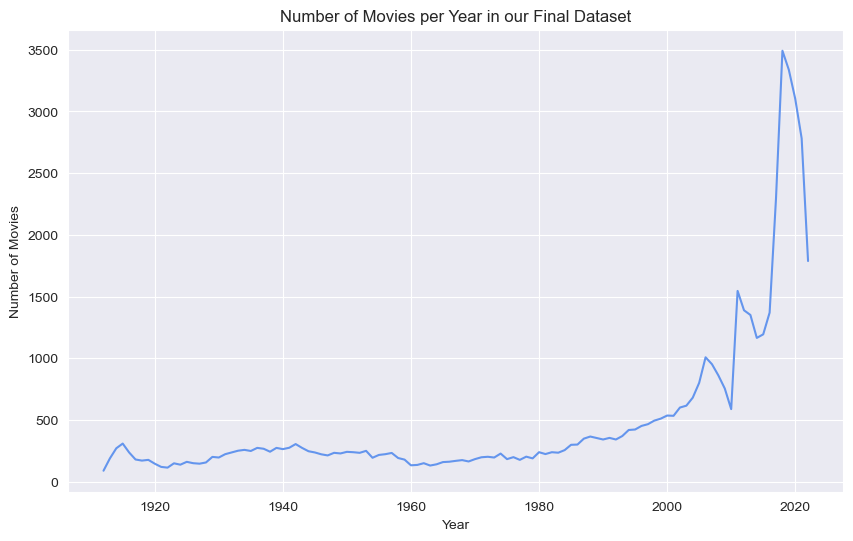

In [39]:
# Group movies by release year
movies_grouped_by_year = movie_data.groupby(movie_data['release_date'])

#number of movies per year
number_movies_per_year = movies_grouped_by_year.size()

plt.figure(figsize=(10, 6))
number_movies_per_year.plot(kind='line', color = 'cornflowerblue')
plt.title('Number of Movies per Year in our Final Dataset')
plt.xlabel('Year')
plt.ylabel('Number of Movies')
plt.grid(True)
plt.show()

We see that we have many more movies from 2010 to 2022 than in previous years since we complemented the dataset with more than 20'000 movies in just 10 years. This should not be a problem since we will conduct our analysis per year and thus our results will be always be normalized with the number of movies for each year.

We now have a data sets containing movies until 2022 that is ready for our analysis! We will save it so that we do not have to re-run this part of the code and can easily use it in other notebooks.


### B) Complementing and cleaning up the genres of the movie data
<a id='subsection-5.2'></a>

In [40]:
nan_genre_count = movie_data['genre'].isna().sum()
print(f"Number of entries with NaN values in 'genre' column: {nan_genre_count}")

Number of entries with NaN values in 'genre' column: 354


In [41]:
movie_data.dropna(subset=['genre'], inplace=True)

In [42]:
nan_genre_count = movie_data['genre'].isna().sum()
print(f"Number of entries with NaN values in 'genre' column: {nan_genre_count}")

Number of entries with NaN values in 'genre' column: 0


#### Removing adult films

As they do not add any value to our analysis and to prevent us from having to have to deal with pornographic content we remove these movies. As this only concerns 158 entries this should not have a negative effect on our analysis.

In [43]:
porn_genres=['Softcore Porn','Gay pornography','Hardcore pornography','Pornography','Pornographic movie','Adult']
porn_movies=movie_data[movie_data['genre'].apply(lambda genre_list:
                                                 any(item in genre_list for item in porn_genres))]
movie_data=movie_data[~movie_data["wikipedia_ID"].isin(porn_movies.wikipedia_ID.values)]

In [44]:
genres_flat=[item for sublist in movie_data["genre"].values for item in sublist]
genres_count=Counter(genres_flat)
genres_count

Counter({"'": 81588,
         'r': 39283,
         'a': 28769,
         '[': 23528,
         ']': 23528,
         'o': 23383,
         'm': 23288,
         'e': 21882,
         ',': 17266,
         ' ': 17266,
         'y': 16624,
         'D': 14678,
         'i': 14335,
         't': 13610,
         'n': 13038,
         'c': 12207,
         'Drama': 11726,
         'l': 9323,
         'Comedy': 8929,
         'u': 8505,
         'C': 5724,
         'Black-and-white': 5722,
         'd': 5210,
         'Indie': 4977,
         'h': 4849,
         'Thriller': 4448,
         's': 4200,
         'Short Film': 4130,
         'Romance Film': 4097,
         'T': 4094,
         'Action': 4034,
         'H': 3982,
         'A': 3550,
         'Crime Fiction': 3257,
         'F': 2893,
         'Silent film': 2817,
         'Action/Adventure': 2802,
         'Adventure': 2760,
         'Horror': 2673,
         'Family Film': 2438,
         'M': 2438,
         'Documentary': 2327,
         'S': 

#### Genres preprocessing

We can see that there are many genres contained in the database. However they are not uniform, some are very broad (_e.g._ Drama) while some are very precise (_e.g._ Women in prison films). Additionnaly some of the "genres" are in reality not movie genres but rather tyoes of movies such as "Black and white" or "Short films". We therefore have to determine a list of genres we want to keep and recategorize some movies to these new genres. We make a first list with the common genres which we then modify

| Name                   | Note                                                       |
|------------------------|------------------------------------------------------------|
| Drama                  |                                                            |
| Comedy                 |                                                            |
| Indie                  |                                                            |
| Thriller               |                                                            |
| Romance Film           |                                                            |
| Action                 |                                                            |
| Crime Fiction          | Merge with crime   thriller into new Crime genre           |
| Action/Adventure       | Has to be merged with   action and adventure               |
| Adventure              |                                                            |
| Horror                 |                                                            |
| Family Film            |                                                            |
| Documentary            |                                                            |
| Science Fiction        |                                                            |
| Romantic comedy        |                                                            |
| Mystery                |                                                            |
| Musical                |                                                            |
| Western                |                                                            |
| Animation              |                                                            |
| Fantasy                |                                                            |
| Crime Thriller         | Add Thriller genre if   not present yet                    |
| Romantic drama         | Has to be merged with   Romantic and Drama                 |
| War film               |                                                            |
| Film adaptation        |                                                            |
| Comedy-drama           | Has to be merged with   comedy and drama                   |
| Biography              |                                                            |
| Psychological thriller |                                                            |
| Comedy film            | Same as comedy, has   to be merged with it                 |
| Teen                   |                                                            |
| Sports                 |                                                            |
| Children's/Family      |                                                            |
| Parody                 |                                                            |
| Black comedy           | Add Comedy if not   present yet                            |
| Family Drama           |                                                            |
| Biographical film      | Same as Biography,   has to be merged with it              |
| Cult                   |                                                            |
| LGBT                   |                                                            |
| Coming of age          |                                                            |
| Slapstick              |                                                            |
| Music                  |                                                            |
| Culture & Society      |                                                            |
| Melodrama              |                                                            |
| Supernatural           |                                                            |
| History                |                                                            |
| Biopic [feature]       | Same as Biography,   has to be merged with it              |
| Satire                 |                                                            |
| Political drama        | Add Drama Genre if   not present yet                       |
| Action Thrillers       | Merge with Thriller                                        |
| Children's             | Merge with   Children's/Family                             |
| Costume drama          | Merge with Drama                                           |
| Crime Drama            | Add Drama if not   present yet & merge into Crime category |
| Spy                    |                                                            |
| Superhero movie        | Merge with Superhero                                       |
|                        | (we keep the Superhero name   for simplicity)              |
| War film               | Merge with War                                             |
|Period piece||

In [45]:
genres_to_keep=['Drama','Comedy','Indie','Thriller','Romance Film','Action','Crime Fiction','Action/Adventure',
                'Adventure','Horror','Family Film','Documentary','Science Fiction','Romantic comedy','Mystery',
                'Western','Musical','Animation','Fantasy','Crime Thriller','Romantic drama','War film',
                'Film adaptation','Comedy-drama','Biography','Psychological thriller','Comedy film','Teen',
                'Sports',"Children's/Family",'Parody','Black comedy','Family Drama','Biographical film','Cult',
                'LGBT','Coming of age','Slapstick','Music','Culture & Society','Melodrama','Supernatural','History',
                'Biopic [feature]','Satire','Political drama','Action Thrillers',"Children's",'Costume drama',
                'Crime Drama','Spy','Superhero','Period piece']
genres_to_remove=[item for item in list(genres_count) if item not in genres_to_keep]

#### Movies where none of their genres are contained in the list above

We define a function which searches for these movies. This function finds all movies where none of their genres are contained in the list of genres we want to keep.

In [46]:
foo=no_genres_in_list(genres=genres_to_remove, df=movie_data)

Number of movies :  24171


In [47]:
movie_data

,wikipedia_ID,freebase_ID,name,release_date,box_office_revenue,runtime,genre,plot_summary,IMDB_ID
0,975900.0,/m/03vyhn,ghosts of mars,2001,14010832.0,98.0,"[Thriller, Science Fiction, Horror, Adventure,...","Set in the second half of the 22nd century, th...",NaN
1,3196793.0,/m/08yl5d,getting away with murder: the jonbenét ramsey ...,2000,NaN,95.0,"[Mystery, Biographical film, Drama, Crime Drama]",NaN,NaN
2,13696889.0,/m/03cfc81,the gangsters,1913,NaN,35.0,"[Short Film, Silent film, Indie, Black-and-whi...",NaN,NaN
3,10408933.0,/m/02qc0j7,alexander's ragtime band,1938,3600000.0,106.0,"[Musical, Comedy, Black-and-white]",NaN,NaN
4,175026.0,/m/017n1p,sarah and son,1930,NaN,86.0,"[Drama, Black-and-white]",NaN,NaN
...,...,...,...,...,...,...,...,...,...
53552,NaN,NaN,swarm season,2019,NaN,NaN,['Documentary'],"[""On the remote volcanic island of Hawaii, 10-...",tt9913056
53553,NaN,NaN,letters,2020,NaN,NaN,['Drama'],"[""Charlie Porter is an ordinary man. He leads ...",tt9913288
53554,NaN,NaN,the holden family plan,2019,NaN,NaN,"['Drama', 'Family']","[""When Mackenzie Holden's sister and brother i...",tt9914522
53555,NaN,NaN,however long,2019,NaN,NaN,['Documentary'],['Documentary following four women with incura...,tt9914582


In [48]:
uniquegenres_df = movie_data[movie_data['name'].isin(foo)]
uniquegenres_flat = [item for sublist in uniquegenres_df["genre"].values for item in sublist]
uniquegenres_count = Counter(uniquegenres_flat)
uniquegenres_count

Counter({"'": 81588,
         'r': 39283,
         'a': 28769,
         '[': 23528,
         ']': 23528,
         'o': 23383,
         'm': 23288,
         'e': 21882,
         ',': 17266,
         ' ': 17266,
         'y': 16624,
         'D': 14678,
         'i': 14335,
         't': 13610,
         'n': 13038,
         'c': 12207,
         'l': 9323,
         'u': 8505,
         'C': 5724,
         'd': 5210,
         'h': 4849,
         's': 4200,
         'T': 4094,
         'H': 3982,
         'A': 3550,
         'F': 2893,
         'M': 2438,
         'S': 1761,
         'R': 1532,
         '-': 1300,
         'p': 1296,
         'Drama': 1232,
         'v': 1029,
         'B': 794,
         'g': 794,
         'Black-and-white': 601,
         'Comedy': 579,
         'Thriller': 568,
         'Short Film': 524,
         'W': 487,
         'Indie': 451,
         'Romance Film': 392,
         'Silent film': 336,
         'Crime Fiction': 334,
         'Action': 314,
         'Horro

The only genres which appear a significant number of times are Silent film , black & white and silent films. All three are not real movie genres but rather describe movie type. We still keep them and add them to the list of genres. We than take the rest of the genres and assign them to new categories if possible (_e.g_ Film noir to crime and drama , Mockumentary to documentary) or otherwise removing them. To remove them we remove their genre and they will then be removed when removing the movies with no genres
Given the high number of movies in the dataset, removing this amount of movies will not have a significant effect and therefore manually reassigning them new genres would not be a viable time investment.

In [49]:
genres_to_keep.append(['Short Film','Black-and-white','Silent film'])
genres_to_remove=[item for item in list(genres_count) if item not in genres_to_keep]

In [50]:
genre_equivalence={
 'Film noir':[],
 'Propaganda film':[],
 'Art film':[],
 'Slasher':['Horror'],
 'Concert film':[],
 'Stop motion':[],
 'Blaxploitation':[],
 'Pre-Code':[],
 'Hip hop movies':[],
 'Chinese Movies':[],
 'World cinema':[],
 'Sponsored film':[],
 'Animated cartoon':['Animation'],
 'Christian film':[],
 'Japanese Movies':[],
 'Surrealism':[],
 'Swashbuckler films':['Adventure'],
 'Superhero movie':['Superhero'],
 'Historical drama':['Drama'],
 'Christmas movie':[],
 'Rockumentary':['Documentary'],
 'Computer Animation':['Animation'],
 'Auto racing':[],
 'Experimental film':[],
 'Avant-garde':[],
 'Dance':[],
 'Historical Epic':[],
 'Historical fiction':[],
 'Detective fiction':[],
 'Comedy horror':['Comedy','Horror'],
 'Detective':[],
 'Erotica':[],
 'Foreign legion':[],
 'Mockumentary':['Documentary'],
 'Fan film':[],
 'Martial Arts Film':[],
 'Dogme 95':[],
 'Musical comedy':['Comedy'],
 'Sword and sorcery':[],
 'Suspense':[],
 'Anime':[],
 'Filipino Movies':[],
 'Period piece':[],
 'Screwball comedy':['Comedy'],
 'Singing cowboy':[],
 'Northern':[],
 'Television movie':[],
 'Time travel':[],
 'Disaster':[],
 'Anti-war':[],
 'Religious Film':[],
 'Punk rock':[],
 'Exploitation':[],
 'Computers':[],
 'Business':[],
 'Sexploitation':[],
 'Gay Interest':[],
 'Gay':[],
 'Gay Themed':[],
 'Outlaw biker film':[],
 'Sci-Fi Horror':['Horror','Science Fiction'],
 'Race movie':[],
 'Educational':[],
'Crime Fiction':['Crime'],
'Action/Adventure':['Action','Adventure'],
    'Romantics drama':['Romantic','Drama'],
    'Comedy-drama':['Comedy','Drama'],
    'Comedy-film':['Comedy'],
    'Biographical film':['Biography'],
    'Biopic [feature]':['Biography'],
    "Children's":["Children's/Family"],
    'Crime Drama':['Drama','Crime'],
    'Superhero movie':['Superhero'],
    'Crime Thriller':['Crime','Thriller'],
    'Action Thrillers':['Thriller'],
    'War film':['War']
}

We can then use this equivalence table to remove the unwanted genres

In [51]:
def replace_elements_in_list(lst):
    return [replacement for item in lst for replacement in genre_equivalence.get(item, [item])]
movie_data['genre'] = movie_data['genre'].apply(replace_elements_in_list)

C:\Users\lucil\AppData\Local\Temp\ipykernel_1548\759356878.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movie_data['genre'] = movie_data['genre'].apply(replace_elements_in_list)


We now also the modification where we add the genres if not present yet , we do not care about duplicates as we will remove them in a later step

In [52]:
genre_equivalence_add={
    'Crime Thriller':['Crime','Thriller'],
    'Black comedy':['Comedy'],
    'Political drama':['Drama'],
    'Crime Drama':['Crime','Drama']
}

In [53]:
def add_entries_to_list(lst):
    return lst + [entry for item in lst for entry in genre_equivalence_add.get(item, [])]
movie_data['genre'] = movie_data['genre'].apply(add_entries_to_list)

C:\Users\lucil\AppData\Local\Temp\ipykernel_1548\1127358969.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movie_data['genre'] = movie_data['genre'].apply(add_entries_to_list)


We now redefine the list of accepted genres and use them to remove all unwanted genres

In [54]:
genres_to_keep=['Drama','Comedy','Indie','Thriller','Romance Film','Action','Adventure','Horror',
                'Family Film','Documentary','Science Fiction','Romantic comedy','Mystery','Musical',
                'Western','Animation','Fantasy','War film','Film adaptation','Biography',
                'Psychological thriller','Teen','Sports',"Children's/Family",'Parody','Black comedy',
                'Family Drama','Biographical film','Cult','LGBT','Coming of age','Slapstick','Music',
                'Culture & Society','Melodrama','Supernatural','History','Satire','Political drama',
                'Spy','Superhero','Period piece']

In [55]:
def filter_elements_in_list(lst):
    return [item for item in lst if item in genres_to_keep]

movie_data['genre']=movie_data['genre'].apply(filter_elements_in_list)

C:\Users\lucil\AppData\Local\Temp\ipykernel_1548\8070288.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movie_data['genre']=movie_data['genre'].apply(filter_elements_in_list)


#### Removing duplicates

In [56]:
movie_data['genre']=movie_data['genre'].apply(lambda x: list(set(x)))

C:\Users\lucil\AppData\Local\Temp\ipykernel_1548\354113090.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movie_data['genre']=movie_data['genre'].apply(lambda x: list(set(x)))


In [57]:
movie_data

,wikipedia_ID,freebase_ID,name,release_date,box_office_revenue,runtime,genre,plot_summary,IMDB_ID
0,975900.0,/m/03vyhn,ghosts of mars,2001,14010832.0,98.0,"[Thriller, Horror, Supernatural, Science Ficti...","Set in the second half of the 22nd century, th...",NaN
1,3196793.0,/m/08yl5d,getting away with murder: the jonbenét ramsey ...,2000,NaN,95.0,"[Drama, Biography, Mystery]",NaN,NaN
2,13696889.0,/m/03cfc81,the gangsters,1913,NaN,35.0,"[Comedy, Indie]",NaN,NaN
3,10408933.0,/m/02qc0j7,alexander's ragtime band,1938,3600000.0,106.0,"[Comedy, Musical]",NaN,NaN
4,175026.0,/m/017n1p,sarah and son,1930,NaN,86.0,[Drama],NaN,NaN
...,...,...,...,...,...,...,...,...,...
53552,NaN,NaN,swarm season,2019,NaN,NaN,[],"[""On the remote volcanic island of Hawaii, 10-...",tt9913056
53553,NaN,NaN,letters,2020,NaN,NaN,[],"[""Charlie Porter is an ordinary man. He leads ...",tt9913288
53554,NaN,NaN,the holden family plan,2019,NaN,NaN,[],"[""When Mackenzie Holden's sister and brother i...",tt9914522
53555,NaN,NaN,however long,2019,NaN,NaN,[],['Documentary following four women with incura...,tt9914582


In [58]:
movie_data.to_csv(data_folder + 'movie_data.csv', index=False)

**Missing values**

In [59]:
number_of_data_movie = movie_data.count()
proportion_of_each_data_movie = number_of_data_movie/number_of_data_movie['release_date']*100
proportion_of_each_data_movie

wikipedia_ID           55.600845
freebase_ID            55.600845
name                  100.000000
release_date          100.000000
box_office_revenue     12.766078
runtime                49.371603
genre                 100.000000
plot_summary           73.573370
IMDB_ID                44.929423
dtype: float64

In our dataset from 1912 to 2022 we have less than 50% of box office revenue and movie run time. We are not planning to use these variables in our analysis so we do not need to complement them. Other variables of interest (genre, release date, plot summary) are all above 70% complete. We thus concluded that we do not need to further complement the movie dataset

### C) Complementing characters' data
<a id='subsection-5.3'></a>
To complete the character dataset the following folders need to be downloaded from https://datasets.imdbws.com/, unzipped and placed in the /DATA folder:
- title.principals.tsv.gz
- name.basics.tsv.gz

In [60]:
# load characters info
characters_data = pd.read_csv(data_folder + 'title.principals.tsv/data.tsv', sep='\t')
IMDB_ids = IMDB_movie_data_filtered['IMDB_ID']
# only keep characters of the filtered movies
characters_data_filtered = clean_IMDB_character_dataset(characters_data, IMDB_ids)

C:\Users\lucil\OneDrive\Documents\EPFL\MA3\ADA\ada-2023-project-badabob\helpers.py:200: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  characters_data.loc[characters_data['category'] == 'actor', 'actor_gender'] = 'M'


In [61]:
# load actors info
actors_data = pd.read_csv(data_folder + 'name.basics.tsv/data.tsv', sep='\t')
# remove useless columns
actors_data = actors_data.drop(columns=['deathYear', 'primaryProfession', 'knownForTitles'])

We now need to merge all the information we have on the characters and the actors. There are some information we still need to add to the dataframe: release date, actor age, movie name. These will be added by merging with the movie dataset created above.

In [62]:
# merge actor data and movie data on character data
IMDB_characters_data = merge_datasets_characters(characters_data_filtered, actors_data, IMDB_movie_data_filtered)
IMDB_characters_data.loc[IMDB_characters_data['character_name'] == '\\N', 'character_name'] = None

In [63]:
IMDB_characters_data

,IMDB_ID,actor_IMDB_ID,character_name,actor_gender,actor_name,name,release_date,actor_age
0,tt0172182,nm0182661,Bum Joe,M,Nicolas Coster,blood type,2018,85.0
1,tt0172182,nm0500098,Tiffanie,F,Hudson Leick,blood type,2018,49.0
2,tt0172182,nm0090981,Chad,M,Wolfgang Bodison,blood type,2018,52.0
3,tt0172182,nm0001730,Mrs. Dow,F,Deborah Shelton,blood type,2018,70.0
4,tt0293429,nm1167985,Cole Young,M,Lewis Tan,mortal kombat,2021,NaN
...,...,...,...,...,...,...,...,...
76655,tt9914522,nm7997361,Evan,M,Caleb Silvers,the holden family plan,2019,24.0
76656,tt9914522,nm2246717,Mackenzie,F,Bethany Hazelitt,the holden family plan,2019,29.0
76657,tt9914522,nm10172541,Evan's dad,M,Joshua Bootz,the holden family plan,2019,NaN
76658,tt9914522,nm10537291,Todd,M,Vince Camaj,the holden family plan,2019,NaN


We can now merge this IMDB character dataset with the provided character dataset

In [64]:
provided_characters = character_metadata_noNA_genderYear_personnas

In [65]:
#first put all strings in lower case
provided_characters['character_name'] = name_to_lowercase(provided_characters, 'character_name')
provided_characters['actor_name'] = name_to_lowercase(provided_characters, 'actor_name')
provided_characters['name'] = name_to_lowercase(provided_characters, 'name')
IMDB_characters_data['character_name'] = name_to_lowercase(IMDB_characters_data, 'character_name')
IMDB_characters_data['actor_name'] = name_to_lowercase(IMDB_characters_data, 'actor_name')
IMDB_characters_data['name'] = name_to_lowercase(IMDB_characters_data, 'name')

Since we do not have the wikipedia IDs of the movie scraped on IMDB and the IMDB IDs of the movies in the original dataset, we cannot do a merge on a unique ID. We thus perform the merge on multiple columns (movie name, actor name and release date). We decided to not use the character name column since it would assume that, for the same character, the character name is the same in both datasets. This is not true. Sometimes the characters are identified only by their first names or only by their last names, sometimes by their nicknames and sometimes by their first and last names in both datasets. Additionally, in the provided dataset, sometimes a character is present twice because it has 2 different names and this is not the case in the IMDB dataset. After the merge, when we have information on characters from both datasets, we will keep only the character name of the IMDB dataset and then remove duplicates. This should remove characters that are doubled in the provided dataset because they have two different names.

One caveat of this merge method is that the merge will not be accurate if one actor plays two different characters in the same movie or in a movie of the same year with the same name. However, we are assuming that this event is rare enough and that we have enough data so that it doesn't influence our analysis too much.

In [66]:
# merge datasets
characters_data = pd.merge(provided_characters, IMDB_characters_data,
                           on=['name', 'actor_name', 'release_date'], how='outer').copy()
# remove columns that were duplicated
duplicated_cols = ['actor_gender', 'actor_age']
characters_data= remove_duplicated_columns(characters_data, duplicated_cols)
characters_data = remove_duplicated_columns(characters_data, ['character_name'],
                                            col_to_keep='_y', col_to_delete='_x')
# change NA to None
characters_data['actor_gender'].replace('NA', None, inplace=True)
# remove potential duplicates but keep NaNs
characters_data = characters_data.drop_duplicates(subset=['character_name', 'actor_name', 'release_date', 'name'])

In [67]:
characters_data

,wikipedia_ID,freebase_ID,release_date,actor_birthday,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,freebase_character_actor_mapID,freebase_character_ID,freebase_actor_ID,personnas,name,IMDB_ID,actor_IMDB_ID,character_name
0,975900.0,/m/03vyhn,2001.0,1958-08-26,F,1.620,NaN,wanda de jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7,NaN,ghosts of mars,NaN,NaN,akooshay
1,975900.0,/m/03vyhn,2001.0,1974-08-15,F,1.780,/m/044038p,natasha henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4,NaN,ghosts of mars,NaN,NaN,lieutenant melanie ballard
2,975900.0,/m/03vyhn,2001.0,1969-06-15,M,1.727,/m/0x67,ice cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l,NaN,ghosts of mars,NaN,NaN,desolation williams
3,975900.0,/m/03vyhn,2001.0,1967-09-12,M,1.750,NaN,jason statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc,NaN,ghosts of mars,NaN,NaN,sgt jericho butler
4,975900.0,/m/03vyhn,2001.0,1977-09-25,F,1.650,NaN,clea duvall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg,NaN,ghosts of mars,NaN,NaN,bashira kincaid
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
302681,NaN,NaN,2019.0,NaN,M,NaN,NaN,caleb silvers,24.0,NaN,NaN,NaN,NaN,the holden family plan,tt9914522,nm7997361,evan
302682,NaN,NaN,2019.0,NaN,F,NaN,NaN,bethany hazelitt,29.0,NaN,NaN,NaN,NaN,the holden family plan,tt9914522,nm2246717,mackenzie
302683,NaN,NaN,2019.0,NaN,M,NaN,NaN,joshua bootz,NaN,NaN,NaN,NaN,NaN,the holden family plan,tt9914522,nm10172541,evan's dad
302684,NaN,NaN,2019.0,NaN,M,NaN,NaN,vince camaj,NaN,NaN,NaN,NaN,NaN,the holden family plan,tt9914522,nm10537291,todd


We can now plot the number of characters per year to ensure we have data for every year

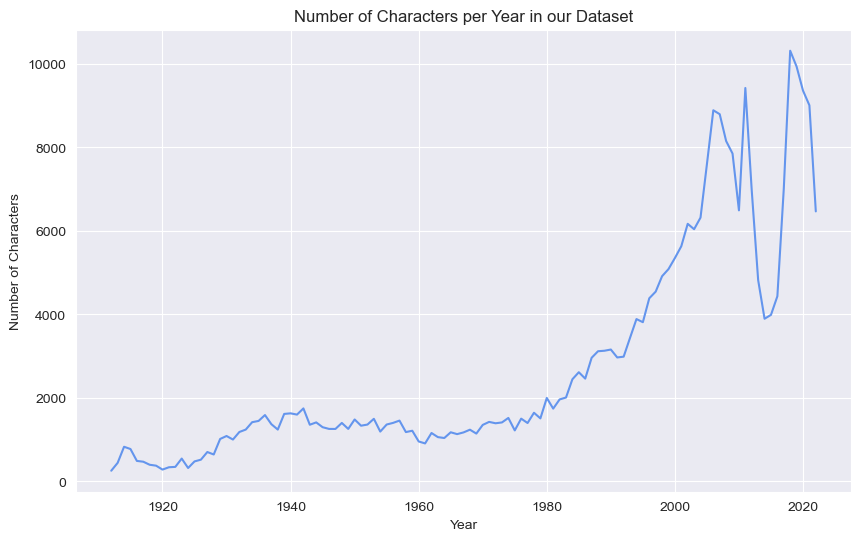

In [68]:
# Group movies by release year
char_grouped_by_year = characters_data.groupby(characters_data['release_date'])

#number of movies per year
number_char_per_year = char_grouped_by_year.size()

plt.figure(figsize=(10, 6))
number_char_per_year.plot(kind='line', color = 'cornflowerblue')
plt.title('Number of Characters per Year in our Dataset')
plt.xlabel('Year')
plt.ylabel('Number of Characters')
plt.grid(True)
plt.show()

Similarly to what we observe in the movie dataset, we also have many more characters per year from 2010 and later. Again, this should not be a problem since we conduct our analysis separately for each year.


We now have a dataset of characters in US movies from 1910 to 2022 ! We will save it so that we do not need to re-run this part of the notebook again

In [69]:
characters_data.to_csv(data_folder + 'characters_data.csv', index=False)

**Missing values**

In [70]:
number_of_data_character= characters_data.count()
proportion_of_each_data_character = \
    number_of_data_character/number_of_data_character['release_date']*100
proportion_of_each_data_character

wikipedia_ID                       74.958689
freebase_ID                        74.958689
release_date                      100.000000
actor_birthday                     61.177359
actor_gender                       94.163871
actor_height                       34.432630
actor_ethnicity                    18.590574
actor_name                         99.847673
actor_age                          59.167630
freebase_character_actor_mapID     74.958689
freebase_character_ID              36.981797
freebase_actor_ID                  74.865637
personnas                           0.138419
name                              100.000000
IMDB_ID                            25.357224
actor_IMDB_ID                      25.357224
character_name                     60.479633
dtype: float64

Variables that are present in less than 50% of the characters are:
- actor height
- actor ethnicity
- Personas

Actor heights and ethnicities are not relevant for our analysis for now and thus do not need to be completed.
Personas however are central to our analysis and will need to be completed. More information on how exactly is in the ReadMe.
Most importantly, the variable central to our analysis, the gender of the actor/actress, is present at 94% and thus do not need to be
completed.

# First Analysis of the character data
<a id='section-6'></a>

## A) Analysis of actors' gender and age
<a id='subsection-6.1'></a>

#### Proportion analysis  
**What's the proportion of female actors in movies per year?**
We wonder if the proportion of female actors' increase over the years, which is what we would expect.

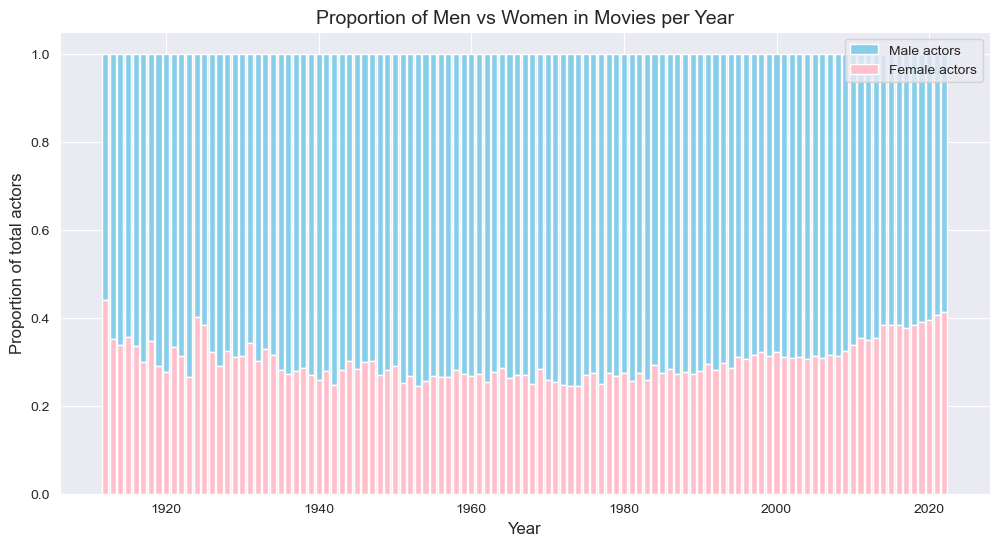

In [71]:
# group the movies by year
#characters_data['release_date'] = pd.to_datetime(characters_data['release_date'])
characters_grouped_by_year = characters_data.groupby(characters_data['release_date'])

# Calculate the proportion of men and women per year
proportion_female = characters_grouped_by_year['actor_gender'].apply(lambda x: (x == 'F').sum() / len(x))
proportion_male = 1 - proportion_female

# Plotting the proportion of men vs women per year as a stacked bar chart
plt.figure(figsize=(12, 6))
plt.bar(proportion_male.index, proportion_male.values, bottom=proportion_female.values, label='Male actors',
        color='skyblue')
plt.bar(proportion_female.index, proportion_female.values, label='Female actors', color='pink')
plt.title('Proportion of Men vs Women in Movies per Year', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Proportion of total actors', fontsize=12)
plt.legend()
plt.show()

Interestingly, the proportion of women over the decades stayed fairly constant, graphically, between 30% and 40%. This constrasts with what we expected as we would think that women representation would get better over the years. Nonetheless, it seems that the proportion of female actors started to increase from the beginning of the 21st century to the 2020s'.

Nevertheless, this result doesn't mean that each movie has approximately 30-40% of women in their actors cast. This result might be biased by movies that have an extremely low/high proportion of women versus movies that have a balanced actors cast. To determine if that is the case, let's plot the proportion of movies per year that have 0-25% actresses, 25-50%, 50-75% or 75-100% actresses. Are female actors represented equally in every movies or is there a discrepency between movies released in the same year?

However, it is important to note that this preliminary analysis does not contain confidence intervals or any statistical analysis to show the significance of the difference. Here we just look at the global trend. We will perform statistical analysis in later steps of the project.

In [72]:
# number of movies per year
number_movies_per_year_character = characters_grouped_by_year.size()

# group by year and by movie
characters_grouped_by_year_and_movie = characters_data.groupby([characters_data['release_date'], 'name'])

# Calculate the proportion of men and women per year per movie
proportion_female_per_movie = \
    characters_grouped_by_year_and_movie['actor_gender'].apply(lambda x: (x == 'F').sum() / len(x))
proportion_male_per_movie = 1 - proportion_female_per_movie

# Convert the Series to a DataFrame for easier data handling in later analysis
female_proportions = proportion_female_per_movie.reset_index()

# Rename the columns if needed
female_proportions.columns = ['release_date', 'name', 'proportion_female']

In [73]:
#Lists to store in which category each movie belongs to per year
below_25_per_year = []
quarter_50_per_year = []
half_75_per_year = []
above_75_per_year = []

# Iterate through each year in the index of female_proportions
for year, proportions in female_proportions.groupby('release_date'):

    # Count movies in different categories for the current year
    below_25 = len(proportions[proportions['proportion_female'] <= 0.25])
    quarter_50 = len(proportions[(proportions['proportion_female'] > 0.25) &
                                 (proportions['proportion_female'] <= 0.5)])
    half_75 = len(proportions[(proportions['proportion_female'] > 0.5) &
                              (proportions['proportion_female'] <= 0.75)])
    above_75 = len(proportions[proportions['proportion_female'] > 0.75])

    # Calculate proportions for each category
    total_movies = len(proportions)
    proportion_below_25 = below_25 / total_movies
    proportion_quarter_50 = quarter_50 / total_movies
    proportion_half_75 = half_75 / total_movies
    proportion_above_75 = above_75 / total_movies

    # Append proportions to respective lists
    below_25_per_year.append(proportion_below_25)
    quarter_50_per_year.append(proportion_quarter_50)
    half_75_per_year.append(proportion_half_75)
    above_75_per_year.append(proportion_above_75)


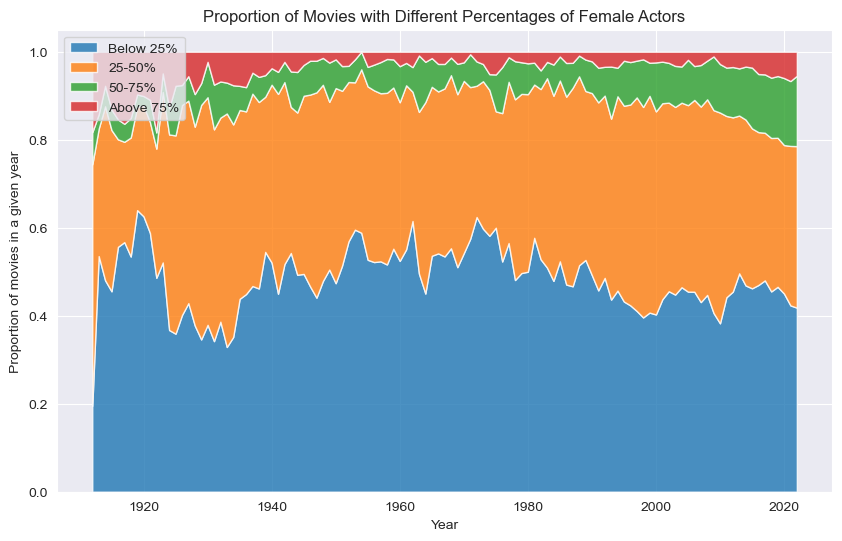

In [74]:
# Extract unique years from the 'release_date' column of the female_proportions DataFrame
unique_years = female_proportions['release_date'].unique()

# Convert the unique years to a list
years = list(unique_years)

# Data for stack plot
categories = ['Below 25%', '25-50%', '50-75%', 'Above 75%']
data = [below_25_per_year, quarter_50_per_year, half_75_per_year, above_75_per_year]

# Create a stack plot
plt.figure(figsize=(10, 6))
plt.stackplot(years, data, labels=categories, alpha=0.8)
plt.xlabel('Year')
plt.ylabel('Proportion of movies in a given year')
plt.title('Proportion of Movies with Different Percentages of Female Actors')
plt.legend(loc='upper left')
plt.show()

We can observe that a vast majority of movies have less than 50% of women actresses in their cast. Actually, over the years, a vast majority of movies (graphically, approximately 85%) have less than 50% female actors in their cast. Thus, even though overall the proportion of women seems to be close to 30-40% over the years, they are largely underrepresented in the vast majority of movies.
However, it might be interesting to note that from 2000 onwards there are more movies with a majority of women actors in their cast, miroring the trend of the overall increase in women's proportion in movies

Yet, it is important to note again that this preliminary analysis does not contain confidence intervals or any statistical analysis to show the significance of the differences. Here we just look at the global trend. We will perform statistical analysis in later steps of the project.

#### Age analysis  
**What's the age difference of female actors in movies compared to male actors over the years? Are female actors significantly younger than male actors?**

In [75]:
# drop the actors with NaN as age but also actors with negative ages (which appeared in 1910)
character_age = characters_data.dropna(subset=['actor_age']).copy()
character_age = character_age[character_age['actor_age'] >= 0] # remove actors with a negative age

In [76]:
# Group by year and gender
characters_age_by_year_gender = character_age.groupby([character_age['release_date'], 'actor_gender'])

# Calculate average age and standard deviation of age for each gender per year
gender_age_stats_per_year = characters_age_by_year_gender['actor_age'].agg(['mean', 'sem'])

# Reset the index to make the grouped columns accessible for further analysis or visualization
gender_age_stats_per_year.reset_index(inplace=True)


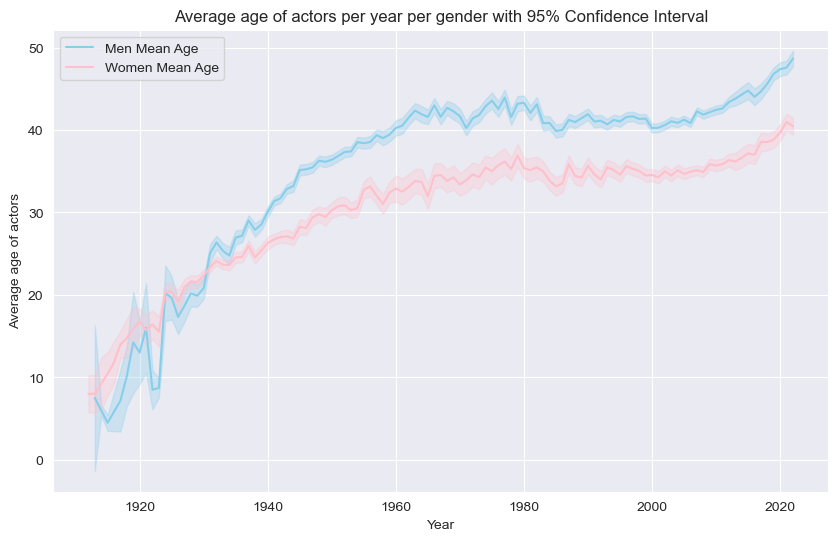

In [77]:
# Filter data for men and women separately for easier handling
men_data = gender_age_stats_per_year[gender_age_stats_per_year['actor_gender'] == 'M'].copy()
women_data = gender_age_stats_per_year[gender_age_stats_per_year['actor_gender'] == 'F'].copy()

# Calculate 95% confidence interval for men
men_data['lower_bound'] = men_data['mean'] - 1.96 * men_data['sem']
men_data['upper_bound'] = men_data['mean'] + 1.96 * men_data['sem']

# Calculate 95% confidence interval for women
women_data['lower_bound'] = women_data['mean'] - 1.96 * women_data['sem']
women_data['upper_bound'] = women_data['mean'] + 1.96 * women_data['sem']

# Plotting for men
plt.figure(figsize=(10, 6))
plt.plot(men_data['release_date'], men_data['mean'], label='Men Mean Age', color='skyblue')
plt.fill_between(men_data['release_date'], men_data['lower_bound'], men_data['upper_bound'],
                 alpha=0.3, color='skyblue')

# Plotting for women
plt.plot(women_data['release_date'], women_data['mean'], label='Women Mean Age', color='pink')
plt.fill_between(women_data['release_date'], women_data['lower_bound'], women_data['upper_bound'],
                 alpha=0.3, color='pink')
plt.xlabel('Year')
plt.ylabel('Average age of actors')
plt.title('Average age of actors per year per gender with 95% Confidence Interval')
plt.legend()
plt.grid(True)
plt.show()

Between approximately 1930 and 2020, female actors are significantly younger than men at the 5% significance level. The results are not significantly different before 1930 as the 95% confidence intervals overlap. We can see that the average age of actors increase over time (both for men and women). This might be because of the long career span of actors as they usually play in several movies over the year. Thus, the actors in 1960 might be the same as the ones in 1980, explaining why tge average age of actors increases.

## B) Personnas Analysis
<a id='subsection-6.2'></a>

**What personas are associated with movie characters interpreted by male and female actors? Are female characters (so female actors) mostly associated with beauty, stupidity, weakness and sexualized and men mostly associated with heroism, adventure, strength...?**

In [78]:
# For the following analysis, drop all the characters that don't have personas
characters_data_personnas_noNA = characters_data.dropna(subset=['personnas']).copy()
display(characters_data_personnas_noNA)

,wikipedia_ID,freebase_ID,release_date,actor_birthday,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,freebase_character_actor_mapID,freebase_character_ID,freebase_actor_ID,personnas,name,IMDB_ID,actor_IMDB_ID,character_name
370,196176.0,/m/01bwgr,1971.0,1937-08-08,M,1.66,/m/041rx,dustin hoffman,34.0,/m/0k3v65,/m/0ch916z,/m/0bl2g,tranquil_fury,straw dogs,NaN,NaN,david sumner
1503,1157158.0,/m/04c13q,2002.0,1969-08-18,M,1.83,NaN,edward norton,32.0,/m/0jx3b8,/m/0gy99_8,/m/01515w,granola_person,death to smoochy,NaN,NaN,sheldon mopes
1866,504242.0,/m/02j9_2,2005.0,1978-05-15,M,1.68,/m/041rx,david krumholtz,27.0,/m/0k31lb,/m/02sgjdt,/m/05cx7x,playful_hacker,serenity,NaN,NaN,mr. universe
2221,6917005.0,/m/0gwypk,2003.0,1962-03-21,M,1.73,/m/041rx,matthew broderick,40.0,/m/04hv61w,/m/09j606t,/m/01vlj1g,charmer,the music man,NaN,NaN,harold hill
2832,445066.0,/m/0299hs,1987.0,1938-07-23,M,1.88,NaN,ronny cox,48.0,/m/0k2m8v,/m/0h5q83s,/m/032qgs,corrupt_corporate_executive,robocop,NaN,NaN,dick jones
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222527,2688769.0,/m/07y2zw,1990.0,1962-11-14,F,1.57,NaN,laura san giacomo,27.0,/m/02tb5g1,/m/0h32zqz,/m/0300lh,ophelia,quigley down under,NaN,NaN,crazy cora
223302,101954.0,/m/0pv3x,1996.0,1960-09-10,M,1.87,/m/0d7wh,colin firth,36.0,/m/0k4_tz,/m/0c0fwm8,/m/03f1zdw,crazy_jealous_guy,the english patient,NaN,NaN,geoffrey clifton
223481,9513043.0,/m/02ph9tm,2008.0,1966-09-09,M,1.78,/m/041rx,adam sandler,41.0,/m/03hqx35,/m/0cb03np,/m/0pz91,warrior_poet,you don't mess with the zohan,NaN,NaN,zohan
225604,52549.0,/m/0dtfn,1977.0,1942-07-13,M,1.85,/m/01qhm_,harrison ford,34.0,/m/0k3r1_,/m/0fjn8,/m/0c0k1,charmer,star wars episode iv: a new hope,NaN,NaN,han solo


In [79]:
# Check values in the "actor_gender" column to make sure it is populated
characters_data_personnas_noNA.loc[characters_data_personnas_noNA.actor_gender.isna(), "actor_gender"] = "NA"
display(characters_data_personnas_noNA.groupby("actor_gender").count().actor_name)

actor_gender
F     59
M    359
Name: actor_name, dtype: int64

From this very simple line, we can already see that out of the 471 characters, only 66 are played by women, which is already a poor representation.

In [80]:
# split the dataframe in 2: one for males and one for women, which is easier for the subsequent analysis
male_personnas_data = characters_data_personnas_noNA[characters_data_personnas_noNA['actor_gender'] == 'M'].copy()
female_personnas_data = characters_data_personnas_noNA[characters_data_personnas_noNA['actor_gender'] == 'F'].copy()

In [81]:
# print the female personas with their number of occurance
unique_female_personnas_counts = female_personnas_data["personnas"].explode().value_counts()
# Sort the unique_personnas_counts Series by the count in descending order
sorted_female_personnas_counts = unique_female_personnas_counts.sort_values(ascending=False)
sorted_female_personnas_counts

personnas
dumb_blonde                 9
brainless_beauty            7
final_girl                  6
chanteuse                   6
prima_donna                 5
granola_person              4
broken_bird                 4
valley_girl                 3
ophelia                     3
eccentric_mentor            2
junkie_prophet              2
doormat                     1
adventurer_archaeologist    1
storyteller                 1
klutz                       1
heartbroken_badass          1
ditz                        1
classy_cat_burglar          1
bully                       1
Name: count, dtype: int64

In [82]:
# Do the same for men
unique_male_personnas_counts = male_personnas_data["personnas"].explode().value_counts()
# Sort the unique_personnas_counts Series by the count in descending order
sorted_male_personnas_counts = unique_male_personnas_counts.sort_values(ascending=False)
print(sorted_male_personnas_counts.head(20))

personnas
corrupt_corporate_executive    23
crazy_jealous_guy              21
psycho_for_hire                14
father_to_his_men              13
byronic_hero                   13
stoner                         11
master_swordsman                9
hitman_with_a_heart             9
arrogant_kungfu_guy             8
bounty_hunter                   8
evil_prince                     7
fastest_gun_in_the_west         7
dirty_cop                       7
hardboiled_detective            7
surfer_dude                     6
retired_outlaw                  6
young_gun                       6
egomaniac_hunter                6
tranquil_fury                   6
big_man_on_campus               6
Name: count, dtype: int64


In [83]:
# Extract the index (unique 'personas') from both DataFrames
female_personnas = sorted_female_personnas_counts.index
male_personnas = sorted_male_personnas_counts.index

# Find the intersection between the two sets of 'personas'
common_personnas = set(female_personnas) & set(male_personnas)

# Create a list of with the common personas and their count in the male and female data
common_personnas_data = [
    {
        'personna': personna,
        'female_count': sorted_female_personnas_counts.get(personna, 0),
        'male_count': sorted_male_personnas_counts.get(personna, 0),
        'normalized_ratio_F_to_M' : (sorted_female_personnas_counts.get(personna, 0)/len(female_personnas_data)) /
                                             (sorted_male_personnas_counts.get(personna, 0)/len(male_personnas_data))
    }
    for personna in common_personnas
]

# Create a DataFrame from the list of dictionaries
common_personnas_df = pd.DataFrame(common_personnas_data)
display(common_personnas_df)

,personna,female_count,male_count,normalized_ratio_F_to_M
0,dumb_blonde,9,1,54.762712
1,bully,1,2,3.042373
2,adventurer_archaeologist,1,3,2.028249
3,doormat,1,3,2.028249
4,heartbroken_badass,1,2,3.042373
5,storyteller,1,3,2.028249
6,brainless_beauty,7,4,10.648305
7,broken_bird,4,1,24.338983
8,ditz,1,5,1.216949
9,eccentric_mentor,2,3,4.056497


This dataframe shows which personas are common for male and female as well as the count for each gender. The last column normalizes the counts of each personas for eah gender and calculates how many times a given personas is more given to women than men. It is sticking how "dumb_blond" is more than 54 times more associated with women than men. Overall, terms with a bad connotation (broken_bird, dumb_blonde, brainless_beauty or bully for example) are much more associated to women than men. However, it is important to remember that the analysis is made only on 471 characters and that no statistical analysis were run on this data, which we will do in a later step of this project.

# Main Character Analysis

We are interested in determining the gender ratio in main characters throughout the years. We made the hypothesis that the female/male ratio will be lower than 0.5 and increasing in recent years. We also hope to see some years with sharp increases that we can correlate to historical events. We perform this analysis using the fuzzywuzzy library to extract the 3 most mentioned names in the movie summary. We assume these characters to be the main characters and then extract the actor's gender from the character metadata. One challenge was to determine the elligible movies for this analysis as some movies lack a summary, some lack a respective list of characters and some have characters for which the name or gender is not listed. We therefore only consider movies that have a summary and for who we can find at least one character for which the name and gender is recorded.

Data wrangling was done in a separate notebook by running the code below. This took over 3 minutes on one of our machines, so we decided to save the resulting dataframe as a csv file and let you import it for time purposes.

In [84]:
# character_metadata = pd.read_csv(data_folder+'characters_data.csv')
# movie_metadata = pd.read_csv(data_folder+'movie_data.csv')
# elligible_movies = select_elligible_movies_for_main_char_analysis(movie_metadata,character_metadata)
# elligible_movies.to_csv("movies_for_main_char_analysis.csv")

elligible_movies = pd.read_csv('DATA/movies_for_main_char_analysis')
elligible_movies = elligible_movies.drop('Unnamed: 0', axis=1)
elligible_movies.head()


,wikipedia_ID,freebase_ID,name,release_date,box_office_revenue,runtime,genre,plot_summary,IMDB_ID
0,77856.0,/m/0kcn7,mary poppins,1964,102272727.0,139.0,"[""Children's/Family"", 'Musical', 'Fantasy', 'C...",The film opens with Mary Poppins perched in a...,NaN
1,12053509.0,/m/02vn81r,loverboy,1989,3960327.0,98.0,"['Romantic comedy', 'Romance Film', 'Comedy']","Randy Bodek is a rebellious college slacker, ...",NaN
2,2154704.0,/m/06qv1c,choke canyon,1986,NaN,94.0,"['Thriller', 'Action Thrillers', 'Science Fict...",Dr. David Lowell's research is carried out in...,NaN
3,33059372.0,/m/0h54gth,chromeskull: laid to rest 2,2011,NaN,93.0,"['Horror', 'Slasher']",ChromeSkull: Laid to Rest 2 picks up three mon...,NaN
4,7460227.0,/m/0kv80y,the bridge,2006,NaN,69.0,['Drama'],Sea Org officer Ronnie Miscavige describes the...,NaN


Extraction of the main characters is computationally intensive, therefore we decided to select only 20 movies (max) per year at random for this milestone. Please note however, that there are very few elligible movies when going back to the first years of this dataset (e.g. only "hinemoa" and "fatty joins the force" in 1913. Sidenote: notice the wording that was acceptable at the time).

In [85]:
sample = elligible_movies.groupby('release_date', group_keys=False).apply(random_movies_per_year)
sample = sample.sort_values('release_date')
sample.tail(10)

,wikipedia_ID,freebase_ID,name,release_date,box_office_revenue,runtime,genre,plot_summary,IMDB_ID
16161,NaN,NaN,moon manor,2022,NaN,NaN,"['Biography', 'Comedy', 'Drama']",['Jimmy throws himself a fabulous FUNeral befo...,tt8946942
6922,NaN,NaN,sleepyhead,2022,NaN,NaN,['Thriller'],['Newly dead Lillo Fante quests through the un...,tt15513434
5990,NaN,NaN,division,2022,NaN,NaN,['Drama'],"[""When a Z-list actress connects with a fan wh...",tt14069588
6101,NaN,NaN,dash,2022,NaN,NaN,"['Drama', 'Thriller']",['An adulterous rideshare driver navigating th...,tt14272430
8035,NaN,NaN,rabbit hole,2022,NaN,NaN,['Adventure'],['The Coin Wars have begun and everyone wants ...,tt19818672
6774,NaN,NaN,out of the blue,2022,NaN,NaN,"['Crime', 'Drama', 'Mystery', 'Romance', 'Thri...","['Connor, a man whose dull life is transformed...",tt15333788
7880,NaN,NaN,captivity,2022,NaN,NaN,['Thriller'],['Ashley is a college student who gets abducte...,tt19177942
9158,NaN,NaN,the darkest place,2022,NaN,NaN,['Horror'],"['The Darkest Place"" involves a teenage girl w...",tt24228490
3019,NaN,NaN,dr. saville's horror show,2022,NaN,NaN,['Horror'],['As the evil Dr. Saville tortures his latest ...,tt10151386
12866,NaN,NaN,marlowe,2022,NaN,NaN,"['Crime', 'Mystery', 'Thriller']","['In late 1930s Bay City, a brooding, down on ...",tt6722802


We now extract the main characters and their respective genders. This was a one-hour computation so we once again provide the csv for you to read.

In [86]:
# sample['main characters'] = sample['plot_summary'].apply(extract_main_characters, nb_sentences=5)
# sample['main character genders'] = sample.apply(find_main_characters_genders,
#                                                 characters_df = character_metadata, axis=1)
# sample.to_csv("main_characters_20_per_year.csv")

main_characters = pd.read_csv("DATA/main_characters_20_per_year")
main_characters.tail()

,Unnamed: 0,wikipedia_ID,freebase_ID,name,release_date,box_office_revenue,runtime,genre,plot_summary,IMDB_ID,main characters,main character genders
1579,37230,NaN,NaN,out of the blue,2022,NaN,NaN,"['Crime', 'Drama', 'Mystery', 'Romance', 'Thri...","['Connor, a man whose dull life is transformed...",tt15333788,"['connor', 'marilyn']","['M', 'F']"
1580,38904,NaN,NaN,captivity,2022,NaN,NaN,['Thriller'],['Ashley is a college student who gets abducte...,tt19177942,"['ashley', 'samuel']","['F', 'M']"
1581,40662,NaN,NaN,the darkest place,2022,NaN,NaN,['Horror'],"['The Darkest Place"" involves a teenage girl w...",tt24228490,[],[]
1582,30066,NaN,NaN,dr. saville's horror show,2022,NaN,NaN,['Horror'],['As the evil Dr. Saville tortures his latest ...,tt10151386,['saville'],['M']
1583,45728,NaN,NaN,marlowe,2022,NaN,NaN,"['Crime', 'Mystery', 'Thriller']","['In late 1930s Bay City, a brooding, down on ...",tt6722802,"['marlowe', 'peterson', 'clare cavendish']","['M', 'F']"


The final step is to calculate the female/male ratio within the main characters for each year. We removed the 20 first rows for visualisation purposes as the first years (around 1920) usually contained less than 3 movies and therefore gave extreme results.

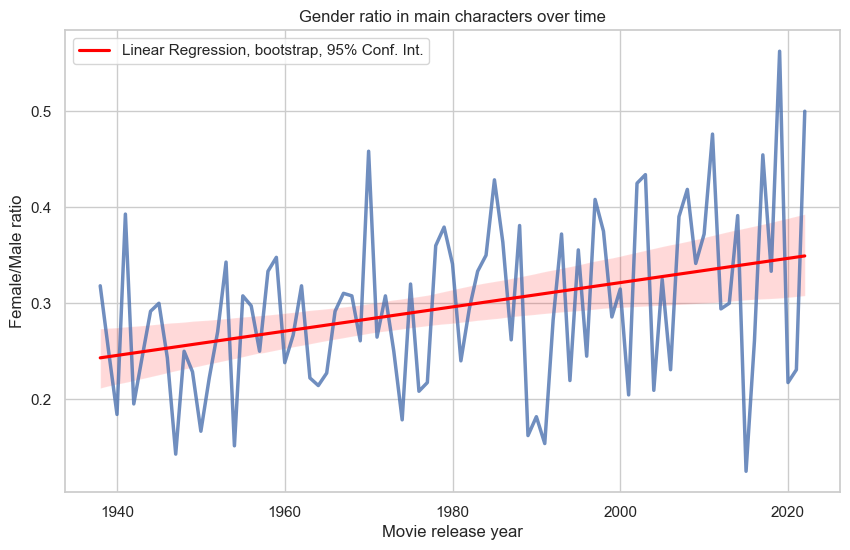

LinregressResult(slope=0.0012638536480166587, intercept=-2.2062120412998283, rvalue=0.35378552532318214, pvalue=0.0008951527878777693, stderr=0.0003667591468243959, intercept_stderr=0.7262388633716935)


In [87]:
gender_list_per_year = main_characters.groupby('release_date')['main character genders'].agg(list).reset_index()
gender_list_per_year['gender_ratio'] = \
    gender_list_per_year['main character genders'].apply(calculate_gender_ratio)
gender_list_per_year = gender_list_per_year[gender_list_per_year['gender_ratio'].notna()]
gender_list_for_plot = gender_list_per_year[20:]
plot_gender_ratio(gender_list_for_plot)

We observe an upwards trend, suggesting that female main characters have increased in popularity. This preliminary analysis is interesting and we conclude that additional investigation into main characters is warranted.

Our method does however present limitations:
1) Most mentioned characters does not necessarily mean "main" character.
2) We do not detect characters that are not mentioned by name (e.g. "teacher", "general").
3) We miss some characters for which the name in the text is not similar enough to the official name.
4) We only observe the first 5 sentences of each summary as well as max 20 movies per year.

We aim to adress these limitations for the final project milestone by reviewing our approach and by running the final pipeline on a larger dataset.